In [ ]:
!pip install --upgrade diffusers transformers scipy
!pip install accelerate
!pip install pillow
!pip install sentence_transformers
# !pip install pytorch_lightning

In [ ]:
!huggingface-cli login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
    
Token: 
Add token as git credential? (Y/n) n
Token is valid.
Your token has been saved to /root/.huggingface/token
Login successful


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline
import tensorflow as tf
from PIL import Image
import numpy as np
from IPython.display import display

model_id = "CompVis/stable-diffusion-v1-4"
device = "cuda"

# Pre trained models

## VGG16

In [ ]:
VGG16 = tf.keras.applications.VGG16(include_top=True, weights='imagenet')
x = VGG16.layers[-2].output
VGG16_MODEL = tf.keras.Model(inputs = VGG16.input, outputs = x)
VGG16_MODEL.trainable = False
VGG16_MODEL.summary()

## CLIP model

In [ ]:
from sentence_transformers import SentenceTransformer, util
from PIL import Image
import glob
import os

# Load the OpenAI CLIP Model
print('Loading CLIP Model...')
clip_model = SentenceTransformer('clip-ViT-B-32')

In [ ]:
def get_clip_encoding(img1, img2):
  encoded_image = clip_model.encode([img1, img2], batch_size=2, convert_to_tensor=True, show_progress_bar=False)
  return encoded_image

# Similarity scores

## Inception score

In [ ]:
from IPython.core.display import ProgressBar
from math import floor
from numpy import ones
from numpy import expand_dims
from numpy import log
from numpy import mean
from numpy import std
from numpy import exp
# load inception v3 model
inception_model = tf.keras.applications.inception_v3.InceptionV3()
def calculate_inception_score(images, eps=1E-16):
  images = np.array(images)
  processed = images.astype('float32')
  # pre-process raw images for inception v3 model
  processed = tf.keras.applications.inception_v3.preprocess_input(processed)
  # predict class probabilities for images
  yhat = inception_model.predict(processed, verbose=False)
  # enumerate splits of images/predictions
  p_yx = yhat
  # calculate p(y)
  p_y = expand_dims(p_yx.mean(axis=0), 0)
  # calculate KL divergence using log probabilities
  kl_d = p_yx * (log(p_yx + eps) - log(p_y + eps))
  # sum over classes
  sum_kl_d = kl_d.sum(axis=1)
  # average over images
  avg_kl_d = mean(sum_kl_d)
  # undo the log
  is_score = exp(avg_kl_d)
  return is_score

96112376/96112376 [==============================] - 1s 0us/step


In [ ]:
from tensorflow.keras.utils import img_to_array
def get_is(img1, img2):
  img1 = copy.deepcopy(img1)
  img2 = copy.deepcopy(img2)
  size = 299, 299
  img1.thumbnail(size)
  img2.thumbnail(size)
  np_img1 = img_to_array(img1)
  np_img2 = img_to_array(img2)
  is_score = calculate_inception_score([np_img1, np_img2])
  return is_score

## L2 norm

In [ ]:
# Helper functions
def image_to_feature_vector(img):
    return np.array(tf.squeeze(VGG16_MODEL(tf.expand_dims(img, 0))))

from numpy.linalg import norm
def similarity(v1, v2):
    v1 /= norm(v1)
    v2 /= norm(v2)
    return 1. - norm(v2 - v1)

In [ ]:
def get_l2_similarity(img1, img2):
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])

  image1 = tf.image.resize_with_pad(img1, 224, 224)
  # Normalize
  image1 = tf.math.divide(image1, 255.)
  image1 = tf.math.subtract(image1, mean)
  image1 = tf.math.divide(image1, std)
  image1 = image_to_feature_vector(image1)

  image2 = tf.image.resize_with_pad(img2, 224, 224)
  # Normalize
  image2 = tf.math.divide(image2, 255.)
  image2 = tf.math.subtract(image2, mean)
  image2 = tf.math.divide(image2, std)
  image2 = image_to_feature_vector(image2)

  sim = similarity(image1, image2)
  return sim

## Cosine similarity

In [ ]:
from scipy.spatial.distance import cosine
def get_cosine_sim(img1, img2):
  return 1 - cosine(img1, img2)

# Stable diffusion

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae", use_auth_token=True)

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet", use_auth_token=True)

Downloading:   0%|          | 0.00/335M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/522 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/961k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/525k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/389 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/905 [00:00<?, ?B/s]

ftfy or spacy is not installed using BERT BasicTokenizer instead of ftfy.


Downloading:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.5.layer_norm1.weight', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.encoder.layers.18.mlp.fc2.bias', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.encoder.layers.4.layer_norm2.weight', 'vision_model.encoder.layers.7.self_attn.q_proj.bias', 'vision_model.encoder.layers.17.self_attn.q_proj.bias', 'vision_model.encoder.layers.13.self_attn.q_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.bias', 'vision_model.encoder.layers.16.self_attn.v_proj.bias', 'vision_model.encoder.layers.1.self_attn.q_proj.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.bias', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.11.self_attn.q_proj.bias', 'vision_model.encoder.layers.0.self_attn.v_proj.weight', 'vision_model.encoder.laye

Downloading:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/743 [00:00<?, ?B/s]

In [ ]:
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

In [ ]:
torch_device = "cuda"
vae.to(torch_device)
text_encoder.to(torch_device)
unet.to(torch_device) 

In [ ]:
# prompt = ["A cave next to a waterfall, 4k HD"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100           # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(1)    # Seed generator to create the inital latent noise

In [ ]:
def prepare_text(prompt, batch_size):
  text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

  max_length = text_input.input_ids.shape[-1]
  uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
  )
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

  text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
  return text_embeddings

In [ ]:
def generate_latents(text_embeddings, batch_size):
  latents = torch.randn(
      (batch_size, unet.in_channels, height // 8, width // 8),
      generator=generator,
  )
  latents = latents.to(torch_device)
  scheduler.set_timesteps(num_inference_steps)
  latents = latents * scheduler.init_noise_sigma
  return latents

In [ ]:
def generate_intermediate_results_per_prompt(latents, text_embeddings):
  scheduler.set_timesteps(num_inference_steps)
  latents_array = []
  intermediate_results = []

  for t in tqdm(scheduler.timesteps):
    # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
    latent_model_input = torch.cat([latents] * 2)

    latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

    # predict the noise residual
    with torch.no_grad():
        noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # perform guidance
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # compute the previous noisy sample x_t -> x_t-1
    latents = scheduler.step(noise_pred, t, latents).prev_sample
    latents_array.append(latents)

  for i, latents in enumerate(latents_array):
    # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    image = vae.decode(latents).sample
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    pil_images[0].save("/content/drive/MyDrive/523/stable_diffusion_intermediate_results/step_" + str(i+1) + ".png")
    intermediate_results.append(pil_images[0])
    # display(pil_images[0])

  return intermediate_results

In [ ]:
for i in range(20):
  torch.cuda.empty_cache()

In [ ]:
import copy
def vgg16_sim(img1, img2):
  img1 = copy.deepcopy(img1)
  img2 = copy.deepcopy(img2)
  size = 224, 224
  img1.thumbnail(size)
  img2.thumbnail(size)
  np_img1 = img_to_array(img1)
  np_img2 = img_to_array(img2)
  # L2 Norm
  l2_sim = get_l2_similarity(np_img1, np_img2)
  # Cosine similarity
  cosine_sim = get_cosine_sim(image_to_feature_vector(np_img1), image_to_feature_vector(np_img2))
  # l2_sim_scores.append(l2_sim)
  # cosine_sim_scores.append(cosine_sim)
  return l2_sim, cosine_sim

In [ ]:
def clip_sim(img1, img2):
  img1 = copy.deepcopy(img1)
  img2 = copy.deepcopy(img2)
  encoded_image = get_clip_encoding(img1, img2)
  l2_sim = similarity(encoded_image[0].cpu(), encoded_image[1].cpu())
  # Cosine similarity
  cosine_sim = get_cosine_sim(encoded_image[0].cpu(), encoded_image[1].cpu())
  return l2_sim, cosine_sim

In [ ]:
from collections import defaultdict
def generate_results(filename):
  images_list = []
  with open(filename) as f:
    lines = [line.rstrip('\n').split(':') for line in f]
  l2_vgg_sim_scores = defaultdict(list)
  cosine_vgg_sim_scores = defaultdict(list)
  l2_clip_sim_scores = defaultdict(list)
  cosine_clip_sim_scores = defaultdict(list)
  inception_scores = defaultdict(list)

  for line in tqdm(lines[:100]):
    batch_size = len(line)
    text_embeddings = prepare_text(line, batch_size)
    latents = generate_latents(text_embeddings, batch_size)
    intermediate_results = generate_intermediate_results_per_prompt(latents, text_embeddings)

    for i in range(len(intermediate_results)-1):
      img1, img2 = intermediate_results[i], intermediate_results[i+1]
      # print(img1, img2)
      l2_vgg_sim, cosine_vgg_sim = vgg16_sim(img1, img2)
      l2_clip_sim, cosine_clip_sim = clip_sim(img1, img2)
      is_score = get_is(img1, img2)

      l2_vgg_sim_scores[f'frame_{i+1}_{i+2}'].append(round(l2_vgg_sim,3))
      cosine_vgg_sim_scores[f'frame_{i+1}_{i+2}'].append(round(cosine_vgg_sim, 3))
      l2_clip_sim_scores[f'frame_{i+1}_{i+2}'].append(round(l2_clip_sim,3))
      cosine_clip_sim_scores[f'frame_{i+1}_{i+2}'].append(round(cosine_clip_sim, 3))   
      inception_scores[f'frame_{i+1}_{i+2}'].append(round(is_score, 3))

  return l2_vgg_sim_scores, cosine_vgg_sim_scores, l2_clip_sim_scores, cosine_clip_sim_scores, inception_scores

In [ ]:
l2_vgg_sim_scores, cosine_vgg_sim_scores, l2_clip_sim_scores, cosine_clip_sim_scores, inception_scores = generate_results("/content/drive/MyDrive/523/new_prompts/text_ptompts_same.txt")

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
cosine_clip_sim_scores

In [ ]:
import csv
def write_to_csv(filename, d):
  with open(filename, "w") as outfile:
   writer = csv.writer(outfile)
   writer.writerow(d.keys())
   writer.writerows(zip(*d.values()))

In [ ]:
write_to_csv("/content/drive/MyDrive/523/l2_vgg_sim_scores.csv", l2_vgg_sim_scores)
write_to_csv("/content/drive/MyDrive/523/cosine_vgg_sim_scores.csv", cosine_vgg_sim_scores)
write_to_csv("/content/drive/MyDrive/523/l2_clip_sim_scores.csv", l2_clip_sim_scores)
write_to_csv("/content/drive/MyDrive/523/cosine_clip_sim_scores.csv", cosine_clip_sim_scores)
write_to_csv("/content/drive/MyDrive/523/inception_scores.csv", inception_scores)

In [ ]:
l2_vgg_sim_scores_avg = {k:np.mean(np.array(v)) for k,v in l2_vgg_sim_scores.items()}
cosine_vgg_sim_scores_avg = {k:np.mean(np.array(v)) for k,v in cosine_vgg_sim_scores.items()}
l2_clip_sim_scores_avg = {k:np.mean(np.array(v)) for k,v in l2_clip_sim_scores.items()}
cosine_clip_sim_scores_avg = {k:np.mean(np.array(v)) for k,v in cosine_clip_sim_scores.items()}
inception_scores_avg = {k:np.mean(np.array(v)) for k,v in inception_scores.items()}

In [ ]:
import matplotlib.pylab as plt
from matplotlib.pyplot import figure

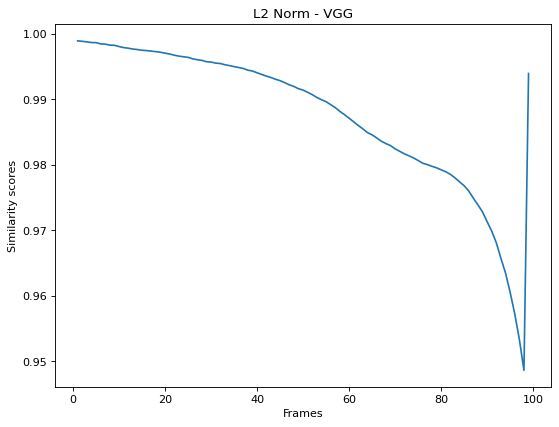

In [ ]:
x, y = zip(*l2_vgg_sim_scores_avg.items()) # unpack a list of pairs into two tuples
figure(figsize=(8, 6), dpi=80)
x = [i for i in range(1, 100)]
plt.plot(x, y)
plt.title("L2 Norm - VGG")
plt.ylabel("Similarity scores")
plt.xlabel("Frames")
plt.show()

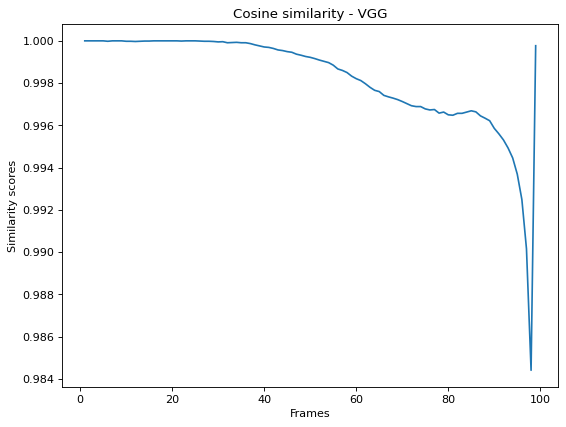

In [ ]:
x, y = zip(*cosine_vgg_sim_scores_avg.items()) # unpack a list of pairs into two tuples
figure(figsize=(8, 6), dpi=80)
x = [i for i in range(1, 100)]
plt.plot(x, y)
plt.title("Cosine similarity - VGG")
plt.ylabel("Similarity scores")
plt.xlabel("Frames")
plt.show()

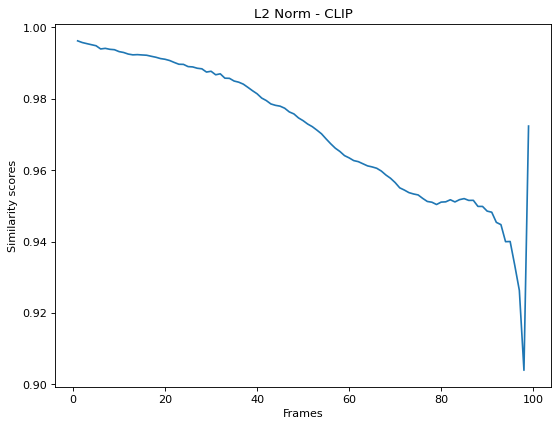

In [ ]:
x, y = zip(*l2_clip_sim_scores_avg.items()) # unpack a list of pairs into two tuples
figure(figsize=(8, 6), dpi=80)
x = [i for i in range(1, 100)]
plt.plot(x, y)
plt.title("L2 Norm - CLIP")
plt.ylabel("Similarity scores")
plt.xlabel("Frames")
plt.show()

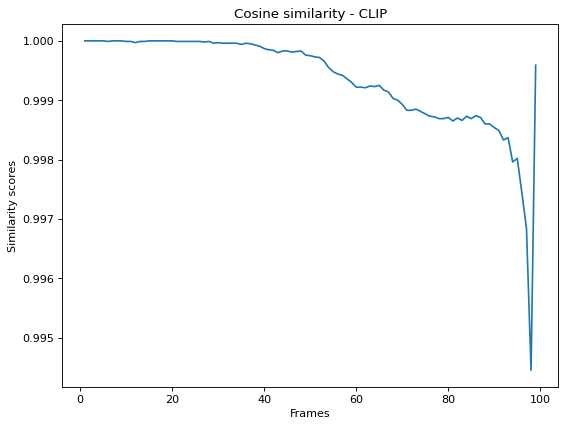

In [ ]:
x, y = zip(*cosine_clip_sim_scores_avg.items()) # unpack a list of pairs into two tuples
figure(figsize=(8, 6), dpi=80)
x = [i for i in range(1, 100)]
plt.plot(x, y)
plt.title("Cosine similarity - CLIP")
plt.ylabel("Similarity scores")
plt.xlabel("Frames")
plt.show()

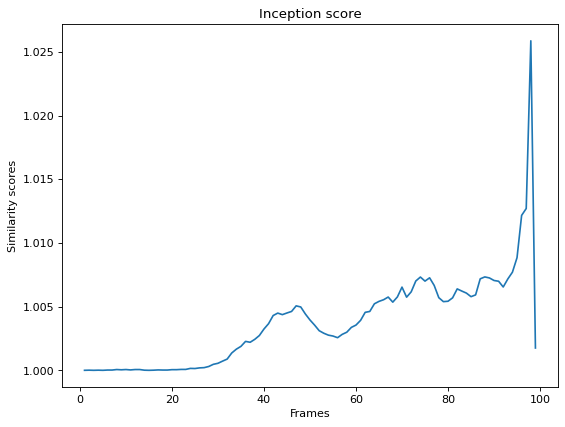

In [ ]:
x, y = zip(*inception_scores_avg.items()) # unpack a list of pairs into two tuples
figure(figsize=(8, 6), dpi=80)
x = [i for i in range(1, 100)]
plt.plot(x, y)
plt.title("Inception score")
plt.ylabel("Similarity scores")
plt.xlabel("Frames")
plt.show()